In [22]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import sys
sys.path.append("..")
from utils_io import get_imaging_files
from utils_image import getMeanTiff_equalsampling, UnrotateCropFrame, RegFrame, hist_match
from scanimagetiffio import SITiffIO   

### read the first tiff file

In [2]:
datafolder = "/media/zilong/4TB Storage HDD/2PImaging/183_03082023"
filenamelist = ["00004"]

#get file triples, including Tiff file, VR logs and RE logs
allfiles = get_imaging_files(datafolder, filenamelist, readVRlogs=True)

tifffile, relogfile, vrlogfile  = allfiles[0]
print ('processing: \n' + tifffile.split('/')[-1] + '\n' + relogfile.split('/')[-1] + '\n' + vrlogfile.split('/')[-1]+'...')

S = SITiffIO()
S.open_tiff_file(tifffile, "r")
S.open_rotary_file(relogfile)
S.open_log_file(vrlogfile)
S.interp_times()  # might take a while...

processing: 
03082023_00004.tif
REdata_20230803_173547.00004.txt
20230803-173552.52.00004.txt...
Loading rotary encoder file: /media/zilong/4TB Storage HDD/2PImaging/183_03082023/REdata_20230803_173547.00004.txt
Calculating rotations and times from rotary encoder data...
Finished calculating rotations and times.
The rotary encoder file has 33177 timestamps in it.

Loading log file: /media/zilong/4TB Storage HDD/2PImaging/183_03082023/20230803-173552.52.00004.txt
Calculating rotations and times from log file data...
Finished calculating rotations and times.
The log file file has 13336 timestamps in it.
Counted 9000 frames


### 1, get the raw mean image from the tiff file

In [4]:
#get the raw mean images from the tiff file
avgImg_raw = getMeanTiff_equalsampling(S, numBins=72)

### 2, unrotated frame and crop the largest rectangle from the frame, and then get the mean image

In [5]:
N = 3000
frames = []
for i in range(1, N+1):
    frames.append(S.get_frame(i))
#convert to numpy array
frames = np.array(frames)
thetas = S.get_all_theta()[:N]

#read the detected center
circlecenterfilename = os.path.join(datafolder, "DP_exp", "circlecenter.txt")
with open(circlecenterfilename, "r") as f:
    # read the last row
    last_line = f.readlines()[-1]
    # assign the x and y coordinates to self.rotx and self.roty
    rotx = float(last_line.split()[0])
    roty = float(last_line.split()[1])
    
unrotframes = UnrotateCropFrame(frames, thetas, rotCenter=[rotx, roty])

#get the average image from the unrotated frames
avgImg_unrot = np.mean(unrotframes, axis=0)

### 3, perform image resgitration on the unrotated frames


In [6]:
#register the unrotated frames
avgImg_reg, regframes = RegFrame(unrotframes)

Reference frame, 6.22 sec.
Registered 200/3000 in 2.43s
Registered 400/3000 in 4.66s
Registered 600/3000 in 6.89s
Registered 800/3000 in 9.13s
Registered 1000/3000 in 11.38s
Registered 1200/3000 in 13.60s
Registered 1400/3000 in 15.64s
Registered 1600/3000 in 17.74s
Registered 1800/3000 in 19.80s
Registered 2000/3000 in 21.85s
Registered 2200/3000 in 23.93s
Registered 2400/3000 in 25.95s
Registered 2600/3000 in 27.88s
Registered 2800/3000 in 29.82s
Registered 3000/3000 in 31.93s


In [7]:
def convertto255(img):
    img = img.astype(np.float32)
    #normalize to 0-1 according to min max
    img = (img - np.min(img))/(np.max(img) - np.min(img))
    img = img*255
    img = img.astype(np.uint8)
    return img

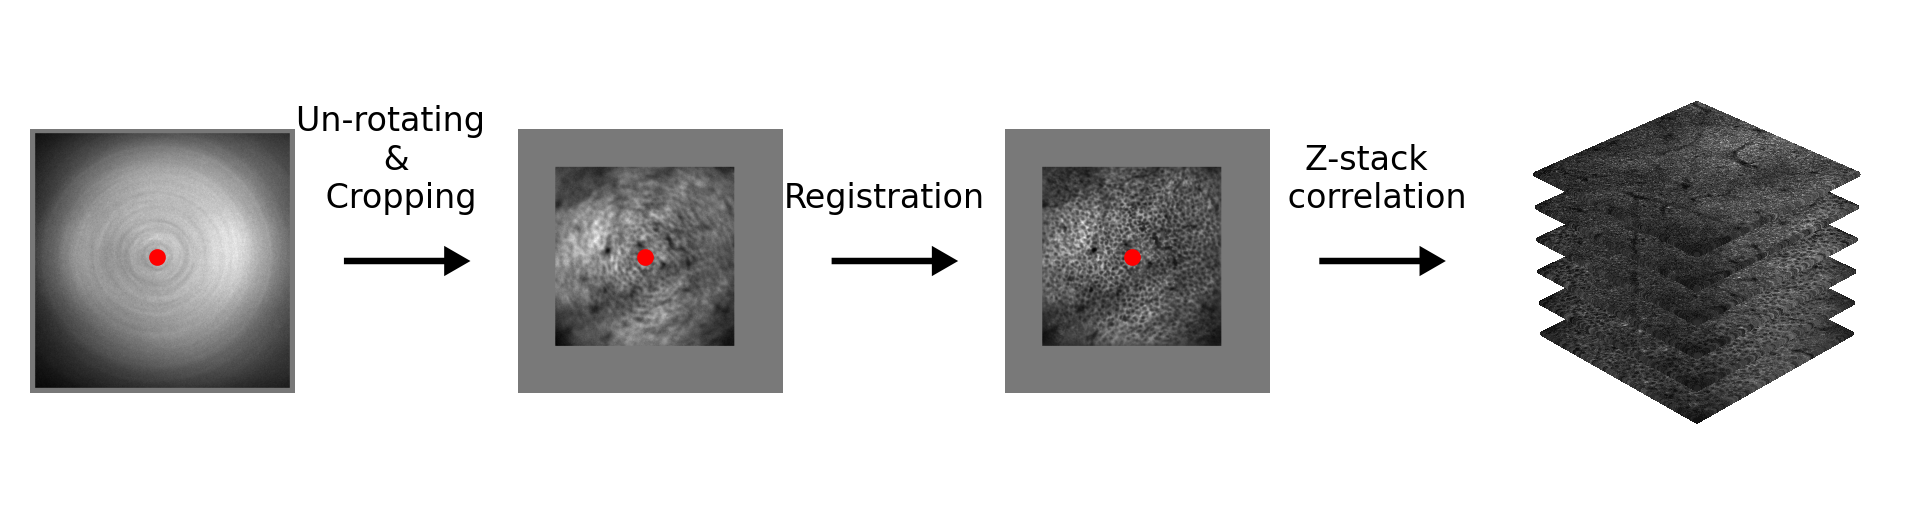

In [31]:
#imshow the averaged image
fig = plt.figure(figsize=(8,2), dpi=300)

labelsize = 10
ticksize = 8
gs = GridSpec(1, 7, width_ratios=[1,0.5,1,0.5,1,0.5,1.5])

#plot aveImg_raw
avgImg_raw = convertto255(avgImg_raw)
ax0 = fig.add_subplot(gs[0])

ax0.imshow(avgImg_raw, cmap='gray')
ax0.set_xticks([]); ax0.set_yticks([])
ax0.axis('off')
#add the center [rotx, roty] as a red dot on the image
ax0.plot(rotx, roty, 'ro', markersize=3)
#equal axis
ax0.set_aspect('equal')

#plot aveImg_unrot
#first init and background image as the mean value and  the same size as avgImg_raw, 
#then plot the unrotated image on the background with the image center at [rotx, roty]
avgImg_unrot = convertto255(avgImg_unrot)
bg_img_unrot = np.ones_like(avgImg_raw, dtype=np.uint8)*np.mean(avgImg_raw)
bg_img_unrot = bg_img_unrot.astype(np.uint8)
rotx = int(rotx)
roty = int(roty)
half_h = avgImg_unrot.shape[0]//2
half_w = avgImg_unrot.shape[1]//2
bg_img_unrot[roty-half_h:roty+half_h, rotx-half_w:rotx+half_w] = avgImg_unrot

# plot a horizontal arrow
ax1 = fig.add_subplot(gs[1])
ax1.arrow(0, 0, 1, 0, head_width=0.01, head_length=0.2, fc='k', ec='k', linewidth=1)
# add text above the arrow to show the step of unrotation
ax1.text(0.5, 0.02, 'Un-rotating \n & \n Cropping', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=ticksize)
ax1.set_ylim(-0.1, 0.1)
#ticks off and axis off
ax1.set_xticks([]); ax1.set_yticks([])
ax1.axis('off')

ax2 = fig.add_subplot(gs[2])

ax2.imshow(bg_img_unrot, cmap='gray')
ax2.set_xticks([]); ax2.set_yticks([])
ax2.axis('off')
#add the center [rotx, roty] as a red dot on the image
ax2.plot(rotx, roty, 'ro', markersize=3)
#equal axis
ax2.set_aspect('equal')

# plot a horizontal arrow with line width 1
ax3 = fig.add_subplot(gs[3])
ax3.arrow(0, 0, 1, 0, head_width=0.01, head_length=0.2, fc='k', ec='k', linewidth=1)
# add text above the arrow to show the step of unrotation, set font size to ticksize
ax3.text(0.5, 0.02, 'Registration', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=ticksize)
ax3.set_ylim(-0.1, 0.1)
#ticks off and axis off
ax3.set_xticks([]); ax1.set_yticks([])
ax3.axis('off')

#plot aveImg_reg
##first init and background image as black the same size as avgImg_raw, 
#then plot the reg image on the background with the image center at [rotx, roty]
avgImg_reg = convertto255(avgImg_reg)
bg_img_reg = np.ones_like(avgImg_raw, dtype=np.uint8)*np.mean(avgImg_raw)
bg_img_reg = bg_img_reg.astype(np.uint8)
rotx = int(rotx)
roty = int(roty)
half_h = avgImg_reg.shape[0]//2
half_w = avgImg_reg.shape[1]//2
bg_img_reg[roty-half_h:roty+half_h, rotx-half_w:rotx+half_w] = avgImg_reg

ax4 = fig.add_subplot(gs[4])

ax4.imshow(bg_img_reg, cmap='gray')
ax4.set_xticks([]); ax4.set_yticks([])
ax4.axis('off')
#add the center [rotx, roty] as a red dot on the image
ax4.plot(rotx, roty, 'ro', markersize=3)
#equal axis
ax4.set_aspect('equal')

# plot a horizontal arrow with line width 1
ax5= fig.add_subplot(gs[5])
ax5.arrow(0, 0, 1, 0, head_width=0.01, head_length=0.2, fc='k', ec='k', linewidth=1)
# add text above the arrow to show the step of unrotation, set font size to ticksize
ax5.text(0.5, 0.02, 'Z-stack \n correlation', 
         horizontalalignment='center', verticalalignment='bottom', fontsize=ticksize)
ax5.set_ylim(-0.1, 0.1)
#ticks off and axis off
ax5.set_xticks([]); ax1.set_yticks([])
ax5.axis('off')


# Create a 3D plot of z stacks in ax6
ax6 = fig.add_subplot(gs[6], projection='3d')

#load meanstacks.npy from datafolder, DP_exp
meanstacks = np.load(os.path.join(datafolder, "DP_exp", "meanstacks.npy"))

center_id = meanstacks.shape[0]//2
total_num = meanstacks.shape[0]
#equally sample N elements from center_id to total_num-1
N = 6
step = (total_num - center_id)//(N-1)
meanstacks_select = meanstacks[center_id:total_num:step]

# Set the image positions in 3D space
z = 0  # Set the initial depth
for image in meanstacks_select:
    # to 0-255
    image = convertto255(image)
    #match the histogram of the image to avgImg_reg
    image = hist_match(image, avgImg_reg)
    # to RGB
    image = np.stack((image,)*3, axis=-1)
    x, y = np.meshgrid(np.linspace(0, 1, image.shape[1]), np.linspace(0, 1, image.shape[0]))
    # Plot the current image
    ax6.plot_surface(x, y, z * 2* np.ones_like(x), facecolors=image / 255.0, rstride=1, cstride=1, antialiased=False)
    z += 1  # Increment the depth for the next image
# Set plot ticks labels off
ax6.set_xticks([]); 
ax6.set_yticks([]); 
ax6.set_zticks([])
ax6.axis('off')
# Show the 3D plot with a different view angle
ax6.view_init(30, 45)

savefolder = os.path.join(datafolder, "UnrotTiff", "2D2P")
plt.savefig(os.path.join(savefolder, "ImageProcessProcedure.pdf"), dpi=300, bbox_inches='tight')
